# Paris - City of Light
## Capstone Project - The Battle of the Neighborhoods
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## I. Introduction: Business Problem <a name="introduction"></a>

In this project we will try to help the **Mayor of Paris** and his colleagues nearby Paris to adjust the **City policies** in order to encourage **social diversity** and to increase the **attractiveness of the neighborhoods**.

Paris is a tremendous city of 2 million inhabitants, with a very rich offer of culture, history but also gastronomy and nature. Around, the "Ile de France" region is the biggest european region in terms of population and GDP. Real estate is quite expensive, and there are important discrepancies among the 20 Paris districts ("Arrondissements") and the cities which are very close to Paris.

Our project will focus on East Paris (10 arrondissements) and 10 surrounding cities close to East Paris. Data collection and interpretation will focus on two distinct parts:
- first, we will examine the **real estate** price per "Arrondissement" or city, based on the available public data of Real Estate transactions. We will calculate the average price per square meter per city.
- second, we will find the most **popular venues** and segment the neighborhoods according to the typology of their venues. Of course, Foursquera will be used to collect the associated data.

Once we have the Real Estate prices associated to each Quartier and the Venues profile, we will try to find a **correlation** between the two types of data and describe what is the **venue segment associated with a "expensive", "medium" and "low price" neighborhood**.

We will than use then our data science powers to make some recommendation for the Mayor in order to adjust the City Policies. Particularly, we will try to find **what kind of venues** should be encouraged in order to increase the **attractiveness of the low price neighborhoods**.

## II. Data <a name="data"></a>

Let's start by importing the necessary libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20200110125505-0000
KERNEL_ID = e9eabdd3-6d22-4ac7-863c-b82c342c9b6f
Solving environment: done

## Package Plan ##

  environment location: /home/spark/shared/conda/envs/python3.6

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages w

libcblas-3.8.0       | 10 KB     | ##################################### | 100% 
pycparser-2.19       | 173 KB    | ##################################### | 100% 
pandas-0.25.3        | 11.4 MB   | ##################################### | 100% 
cryptography-2.8     | 616 KB    | ##################################### | 100% 
altair-4.0.0         | 606 KB    | ##################################### | 100% 
branca-0.3.1         | 25 KB     | ##################################### | 100% 
urllib3-1.25.7       | 160 KB    | ##################################### | 100% 
entrypoints-0.3      | 12 KB     | ##################################### | 100% 
cffi-1.13.2          | 220 KB    | ##################################### | 100% 
pysocks-1.7.1        | 27 KB     | ##################################### | 100% 
libblas-3.8.0        | 10 KB     | ##################################### | 100% 
pytz-2019.3          | 237 KB    | ##################################### | 100% 
python-dateutil-2.8. | 220 K

### II.1 The geographical region we will study

The geographical region we will focus on is East Paris and the cities close to paris on it's East side.

Let's start by having a look on this part of map.

In [2]:
def paris_east ():
    latitude = 48.8534
    longitude = 2.4488
    # create Paris east Map map and display it
    return folium.Map(location=[latitude, longitude], zoom_start=13)

# display the map of East Paris
paris_east_map = paris_east()

paris_east_map

Let's mark on the map the boundaries of the **Cities** and **"Arrondissements"** we are interested in. 

We will use for this the GeoJson file available on https://france-geojson.gregoiredavid.fr

In [3]:
!wget --quiet https://france-geojson.gregoiredavid.fr/repo/regions/ile-de-france/communes-ile-de-france.geojson -O communes-ile-de-france.geojson

def paris_cities (paris_map):

    #windows version of wget
    #import wget

    url = 'https://france-geojson.gregoiredavid.fr/repo/regions/ile-de-france/communes-ile-de-france.geojson'
    #filename = wget.download(url)

    communes_ile_de_france = r'communes-ile-de-france.geojson'
    #print(communes_ile_de_france)
    folium.GeoJson(
        communes_ile_de_france
    ).add_to(paris_map)

    return paris_map

paris_cities(paris_east_map)    
paris_east_map

The **city_list** is the collection of ZIP codes corresponding to the cities or Paris Arrondissements we are interested in

In [4]:
city_list = [75003, 75004, 75005, 75010, 75011, 75012, 75013, 75018, 75019, 75020, 93100, 93110, 93170, 93230, 93260, 93310, 93500, 94120, 94130, 94160, 94220, 94300, 94340, 94410]

### II.2 Data related to real estate transactions

Now let's collect the data associated with the real estate transactions in thsi region.

This data is public, and a full description (in French) can be found on the site below:
https://www.data.gouv.fr/fr/datasets/demandes-de-valeurs-foncieres-geolocalisees/

The brute data can be downloaded using the site https://www.data.gouv.fr/fr/datasets/les-communes-d-ile-de-france-idf/

I have uploaded into the IBM cloud the files corresponding to the real estate sales in 2018 in 3 departments from Ile de France:
    - 75 - Paris
    - 93 - Seine Saint Denis
    - 94 - Val de Marne

They correspond to teh Paris East Region we want to study.

The hidden code below import brute data into 3 pandas Dataframes

In [5]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_5fa043401dd344ca9d75c1ec1d1d6b13 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='fx7y0OF-K29wdDIUzSU6dWi1ypY9vEBzw251_M_qvcaE',
    ibm_auth_endpoint="https://iam.eu-de.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_5fa043401dd344ca9d75c1ec1d1d6b13.get_object(Bucket='pythonbasicsfordatascienceproject-donotdelete-pr-tbucqk0gnlwasx',Key='75_2018.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body)

body = client_5fa043401dd344ca9d75c1ec1d1d6b13.get_object(Bucket='pythonbasicsfordatascienceproject-donotdelete-pr-tbucqk0gnlwasx',Key='93_2018.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_2 = pd.read_csv(body)

body = client_5fa043401dd344ca9d75c1ec1d1d6b13.get_object(Bucket='pythonbasicsfordatascienceproject-donotdelete-pr-tbucqk0gnlwasx',Key='94_2018.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_3 = pd.read_csv(body)

/opt/ibm/conda/miniconda3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (18,20,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/ibm/conda/miniconda3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (14,17,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
#windows version

import os
os.getcwd()
df_data_1 = pd.read_csv('D:\\Python\\WPy64-3741\\notebooks\\coursera_capstone\\Data\\75_2018.csv')
df_data_2 = pd.read_csv('D:\\Python\\WPy64-3741\\notebooks\\coursera_capstone\\Data\\93_2018.csv')
df_data_3 = pd.read_csv('D:\\Python\\WPy64-3741\\notebooks\\coursera_capstone\\Data\\94_2018.csv')

Let's concatenate these data into a sigle dataframe which we will call **restate_primary_data**. 

We get approx. 156,000 lines corresponding to unitary transactions on flats, houses, parkings, shops etc. sold in 2018 in these 3 departments.

In [6]:
df_list = [df_data_1, df_data_2, df_data_3]
restate_primary_data = pd.concat(df_list)

print (restate_primary_data.shape)
restate_primary_data.head()

(156424, 40)


id_mutation date_mutation  numero_disposition nature_mutation  \
0  2018-1276175    2018-01-04                   1           Vente   
1  2018-1276176    2018-01-09                   1           Vente   
2  2018-1276177    2018-01-05                   1           Vente   
3  2018-1276177    2018-01-05                   1           Vente   
4  2018-1276178    2018-01-03                   1           Vente   

   valeur_fonciere  adresse_numero adresse_suffixe  adresse_nom_voie  \
0        1202000.0            10.0             NaN        AV PERCIER   
1         130000.0            20.0             NaN  RUE SAINT CLAUDE   
2          51000.0            24.0             NaN     RUE TREILHARD   
3          51000.0            24.0             NaN     RUE TREILHARD   
4          15000.0            12.0             NaN         RUE VOLTA   

  adresse_code_voie  code_postal  code_commune              nom_commune  \
0              7250      75008.0         75108  Paris 8e Arrondissement   
1              8520      75003.0         75103  Paris 3e Arrondissement   
2              9429      75008.0         75108  Paris 8e Arrondissement   
3              9429      75008.0         75108  Paris 8e Arrondissement   
4              9905      75003.0         75103  Paris 3e Arrondissement   

   code_departement  ancien_code_commune ancien_nom_commune     id_parcelle  \
0                75                  NaN                NaN  75108000CJ0003   
1                75                  NaN                NaN  75103000AL0072   
2                75                  NaN                NaN  75108000CI0004   
3                75                  NaN                NaN  75108000CI0004   
4                75                  NaN                NaN  75103000AE0136   

   ancien_id_parcelle numero_volume lot1_numero  lot1_surface_carrez  \
0                 NaN           NaN          77                159.2   
1                 NaN           NaN         206                  NaN   
2                 NaN           NaN          20                  NaN   
3                 NaN           NaN          27                  NaN   
4                 NaN           NaN           7                  8.3   

  lot2_numero  lot2_surface_carrez  lot3_numero  lot3_surface_carrez  \
0          78                  NaN         79.0                  NaN   
1         213                  NaN        214.0                  NaN   
2         NaN                  NaN          NaN                  NaN   
3         NaN                  NaN          NaN                  NaN   
4         NaN                  NaN          NaN                  NaN   

   lot4_numero  lot4_surface_carrez  lot5_numero  lot5_surface_carrez  \
0          NaN                  NaN          NaN                  NaN   
1        216.0                  NaN          NaN                  NaN   
2          NaN                  NaN          NaN                  NaN   
3          NaN                  NaN          NaN                  NaN   
4          NaN                  NaN          NaN                  NaN   

   nombre_lots  code_type_local   type_local  surface_reelle_bati  \
0            3              2.0  Appartement                120.0   
1            4              2.0  Appartement                 22.0   
2            1              3.0   Dépendance                  NaN   
3            1              3.0   Dépendance                  NaN   
4            1              2.0  Appartement                  9.0   

   nombre_pieces_principales code_nature_culture nature_culture  \
0                        2.0                 NaN            NaN   
1                        1.0                 NaN            NaN   
2                        0.0                 NaN            NaN   
3                        0.0                 NaN            NaN   
4                        1.0                 NaN            NaN   

  code_nature_culture_speciale nature_culture_speciale  surface_terrain  \
0                          NaN  

We will keep only 13 usefull columns ans perform some data cleaning.

In [7]:
restate_primary_data = restate_primary_data[['id_mutation', 'date_mutation', 'numero_disposition', 'nature_mutation', \
                                             'valeur_fonciere', 'adresse_numero', 'adresse_nom_voie', 'code_postal', 'nom_commune', \
                                             'type_local', 'surface_reelle_bati', 'nombre_pieces_principales', 'longitude', 'latitude']]
restate_primary_data[['numero_disposition']] = 1
restate_primary_data.replace({'adresse_numero': np.NaN}, value=0, inplace=True)
restate_primary_data = restate_primary_data.astype({'adresse_numero': 'int64'}, copy=False)
restate_primary_data.replace({'code_postal': np.NaN}, value=0, inplace=True)
restate_primary_data = restate_primary_data.astype({'code_postal': 'int64'}, copy=False)
restate_primary_data.replace({'nombre_pieces_principales': np.NaN}, value=0, inplace=True)
restate_primary_data = restate_primary_data.astype({'nombre_pieces_principales': 'int64'}, copy=False)
restate_primary_data.replace({'surface_reelle_bati': np.NaN}, value=0, inplace=True)
print (restate_primary_data.shape)
restate_primary_data.head()

(156424, 14)


id_mutation date_mutation  numero_disposition nature_mutation  \
0  2018-1276175    2018-01-04                   1           Vente   
1  2018-1276176    2018-01-09                   1           Vente   
2  2018-1276177    2018-01-05                   1           Vente   
3  2018-1276177    2018-01-05                   1           Vente   
4  2018-1276178    2018-01-03                   1           Vente   

   valeur_fonciere  adresse_numero  adresse_nom_voie  code_postal  \
0        1202000.0              10        AV PERCIER        75008   
1         130000.0              20  RUE SAINT CLAUDE        75003   
2          51000.0              24     RUE TREILHARD        75008   
3          51000.0              24     RUE TREILHARD        75008   
4          15000.0              12         RUE VOLTA        75003   

               nom_commune   type_local  surface_reelle_bati  \
0  Paris 8e Arrondissement  Appartement                120.0   
1  Paris 3e Arrondissement  Appartement                 22.0   
2  Paris 8e Arrondissement   Dépendance                  0.0   
3  Paris 8e Arrondissement   Dépendance                  0.0   
4  Paris 3e Arrondissement  Appartement                  9.0   

   nombre_pieces_principales  longitude   latitude  
0                          2   2.315005  48.874705  
1                          1   2.365335  48.860248  
2                          0   2.313122  48.877067  
3                          0   2.313122  48.877067  
4                          1   2.357140  48.864804

Here below is the list of zip codes for the Arrondissements and Cities we would like to study.

We will include the data for these cities into a new dataframe called **df_east_paris_primary**. We get a reduced list of approx. **56,000** elementary transactions.

In [8]:
city_list = [75003, 75004, 75005, 75010, 75011, 75012, 75013, 75018, 75019, 75020, 93100, 93110, 93170, 93230, 93260, 93310, 93500, 94120, 94130, 94160, 94220, 94300, 94340, 94410]

for code_city in city_list:
    if code_city == 75003:
        df_east_paris_primary = restate_primary_data.loc[restate_primary_data['code_postal'] == code_city]
    else:
        df_east_paris_primary = df_east_paris_primary.append(restate_primary_data.loc[restate_primary_data['code_postal'] == code_city])

df_east_paris_primary.shape

(55786, 14)

Let's take a look on how many elementary transactions we have per Arrondissement or City for our **city_list**

In [9]:
df_east_paris_primary.reset_index(drop=True, inplace=True)
df_east_paris_primary.groupby(['code_postal'])['nom_commune'].value_counts()

code_postal  nom_commune             
75003        Paris 3e Arrondissement     1347
75004        Paris 4e Arrondissement     1378
75005        Paris 5e Arrondissement     1383
75010        Paris 10e Arrondissement    3254
75011        Paris 11e Arrondissement    4832
75012        Paris 12e Arrondissement    3703
75013        Paris 13e Arrondissement    2883
75018        Paris 18e Arrondissement    6245
75019        Paris 19e Arrondissement    5134
75020        Paris 20e Arrondissement    3658
93100        Montreuil                   2693
93110        Rosny-sous-Bois             1813
93170        Bagnolet                     984
93230        Romainville                 5685
93260        Les Lilas                   1011
93310        Le Pré-Saint-Gervais         495
93500        Pantin                      1650
94120        Fontenay-sous-Bois          1630
94130        Nogent-sur-Marne            1342
94160        Saint-Mandé                  869
94220        Charenton-le-Pont            

What type of transactions do we have here?

In [10]:
df_east_paris_primary.groupby(['numero_disposition'])['nature_mutation'].value_counts()

numero_disposition  nature_mutation                   
1                   Vente                                 50583
                    Vente en l'état futur d'achèvement     4542
                    Echange                                 382
                    Adjudication                            181
                    Vente terrain à bâtir                    81
                    Expropriation                            17
Name: nature_mutation, dtype: int64

And how many objects have been transacted (appartment, houses, shops etc...)?

In [11]:
df_east_paris_primary.groupby(['numero_disposition'])['type_local'].value_counts()

numero_disposition  type_local                              
1                   Appartement                                 33133
                    Dépendance                                  12819
                    Local industriel. commercial ou assimilé     3842
                    Maison                                       1240
Name: type_local, dtype: int64

We will now keep only simple classical transactions (sale) and we will add category columns for the type of object sold (appartment, house etc.)

In [12]:
index_coll = df_east_paris_primary[df_east_paris_primary['nature_mutation'] == 'Adjudication'].index
index_coll = index_coll.append(df_east_paris_primary[df_east_paris_primary['nature_mutation'] == 'Echange'].index)
index_coll = index_coll.append(df_east_paris_primary[df_east_paris_primary['nature_mutation'] == 'Expropriation'].index)
index_coll = index_coll.append(df_east_paris_primary[df_east_paris_primary['nature_mutation'] == 'Vente terrain à bâtir'].index)
index_coll = index_coll.sort_values()
df_east_paris_primary.drop(index_coll, inplace=True)
df_east_paris_primary = pd.concat([df_east_paris_primary,pd.get_dummies(df_east_paris_primary['type_local'])], axis=1)
df_east_paris_primary.groupby(['numero_disposition'])['nature_mutation'].value_counts()
df_east_paris_primary.head()

id_mutation date_mutation  numero_disposition nature_mutation  \
0  2018-1276176    2018-01-09                   1           Vente   
1  2018-1276178    2018-01-03                   1           Vente   
2  2018-1276181    2018-01-09                   1           Vente   
3  2018-1276181    2018-01-09                   1           Vente   
4  2018-1276181    2018-01-09                   1           Vente   

   valeur_fonciere  adresse_numero  adresse_nom_voie  code_postal  \
0         130000.0              20  RUE SAINT CLAUDE        75003   
1          15000.0              12         RUE VOLTA        75003   
2        1840000.0             251  RUE SAINT MARTIN        75003   
3        1840000.0             251  RUE SAINT MARTIN        75003   
4        1840000.0             251  RUE SAINT MARTIN        75003   

               nom_commune   type_local  surface_reelle_bati  \
0  Paris 3e Arrondissement  Appartement                 22.0   
1  Paris 3e Arrondissement  Appartement                  9.0   
2  Paris 3e Arrondissement   Dépendance                  0.0   
3  Paris 3e Arrondissement   Dépendance                  0.0   
4  Paris 3e Arrondissement  Appartement                180.0   

   nombre_pieces_principales  longitude   latitude  Appartement  Dépendance  \
0                          1   2.365335  48.860248            1           0   
1                          1   2.357140  48.864804            1           0   
2                          0   2.353682  48.866408            0           1   
3                          0   2.353682  48.866408            0           1   
4                          7   2.353682  48.866408            1           0   

   Local industriel. commercial ou assimilé  Maison  
0                                         0       0  
1                                         0       0  
2                                         0       0  
3                                         0       0  
4                                         0       0

Now let's group the elements per transaction. We will keep a **single line per transaction** (while in the original files there was a line per object sold).

At the end, we havve approx. **32,000** of global transactions concerning this geographical zone.

In [13]:
df1 = df_east_paris_primary.groupby(['id_mutation', 'date_mutation', 'nature_mutation', 'code_postal', 'nom_commune'])\
    [['adresse_numero', 'adresse_nom_voie','valeur_fonciere', 'longitude', 'latitude']].max().reset_index()

df2 = df_east_paris_primary.groupby(['id_mutation'])\
    [['numero_disposition', 'surface_reelle_bati', 'Appartement', 'Dépendance', 'Local industriel. commercial ou assimilé', 'Maison', 'nombre_pieces_principales']].sum().reset_index()

df3 = df1.join(df2.set_index('id_mutation'), on='id_mutation')
df3 = df3.astype({'Appartement': 'int64'}, copy=False)
df3 = df3.astype({'Dépendance': 'int64'}, copy=False)
df3 = df3.astype({'Local industriel. commercial ou assimilé': 'int64'}, copy=False)
df3 = df3.astype({'Maison': 'int64'}, copy=False)
print (df3.shape)
df3.head()

(32447, 17)


id_mutation date_mutation nature_mutation  code_postal  nom_commune  \
0  2018-1195952    2018-01-03           Vente        93230  Romainville   
1  2018-1195953    2018-01-08           Vente        93500       Pantin   
2  2018-1195954    2018-01-05           Vente        93170     Bagnolet   
3  2018-1195955    2018-01-05           Vente        93500       Pantin   
4  2018-1195958    2018-01-05           Vente        93260    Les Lilas   

   adresse_numero   adresse_nom_voie  valeur_fonciere  longitude   latitude  \
0              25  BD EMILE GENEVOIX         230000.0   2.435743  48.881934   
1               4      RUE LAPEROUSE          90000.0   2.393240  48.900227   
2               2  RUE DES LORIETTES         222000.0   2.420057  48.872363   
3              31         RUE DELIZY         278000.0   2.408445  48.896071   
4              45   BD DE LA LIBERTE         626400.0   2.420566  48.880405   

   numero_disposition  surface_reelle_bati  Appartement  Dépendance  \
0                   2                 59.0            1           1   
1                   1                 40.0            1           0   
2                   1                 55.0            1           0   
3                   2                 52.0            1           1   
4                   1                110.0            0           0   

   Local industriel. commercial ou assimilé  Maison  nombre_pieces_principales  
0                                         0       0                          3  
1                                         0       0                          3  
2                                         0       0                          3  
3                                         0       0                          2  
4                                         0       1                          5

We will now keep only the transactions concerning the **Appartments** and drop everything else. 

Final data will be stored in **east_paris_transactions** dataframe

In [14]:
index_coll = df3[df3['Local industriel. commercial ou assimilé'] >= 1].index
index_coll = index_coll.append(df3[df3['Maison'] >= 1].index)
index_coll = index_coll.append(df3[df3['Appartement'] < 1].index)
east_paris_transactions = df3.drop(index_coll)
east_paris_transactions.reset_index(drop=True, inplace=True)
print(east_paris_transactions.shape)

(23904, 17)


We will now calculate and enrich the dataframe with the **price per square meter**.

In [15]:
#insert a new column - prix au m2
east_paris_transactions['nombre_transactions'] = 1
east_paris_transactions['prix_m2'] = east_paris_transactions['valeur_fonciere'] / east_paris_transactions['surface_reelle_bati']

east_paris_transactions.head()

id_mutation date_mutation nature_mutation  code_postal  nom_commune  \
0  2018-1195952    2018-01-03           Vente        93230  Romainville   
1  2018-1195953    2018-01-08           Vente        93500       Pantin   
2  2018-1195954    2018-01-05           Vente        93170     Bagnolet   
3  2018-1195955    2018-01-05           Vente        93500       Pantin   
4  2018-1195960    2018-01-05           Vente        93500       Pantin   

   adresse_numero   adresse_nom_voie  valeur_fonciere  longitude   latitude  \
0              25  BD EMILE GENEVOIX         230000.0   2.435743  48.881934   
1               4      RUE LAPEROUSE          90000.0   2.393240  48.900227   
2               2  RUE DES LORIETTES         222000.0   2.420057  48.872363   
3              31         RUE DELIZY         278000.0   2.408445  48.896071   
4             143     AV JEAN LOLIVE         695000.0   2.412250  48.893774   

   numero_disposition  surface_reelle_bati  Appartement  Dépendance  \
0                   2                 59.0            1           1   
1                   1                 40.0            1           0   
2                   1                 55.0            1           0   
3                   2                 52.0            1           1   
4                   3                107.0            1           2   

   Local industriel. commercial ou assimilé  Maison  \
0                                         0       0   
1                                         0       0   
2                                         0       0   
3                                         0       0   
4                                         0       0   

   nombre_pieces_principales  nombre_transactions      prix_m2  
0                          3                    1  3898.305085  
1                          3                    1  2250.000000  
2                          3                    1  4036.363636  
3                          2                    1  5346.153846  
4                          5                    1  6495.327103

Let's take a look at the distribution of price per square meter in our data, city by city. We will use a boxplot graph.

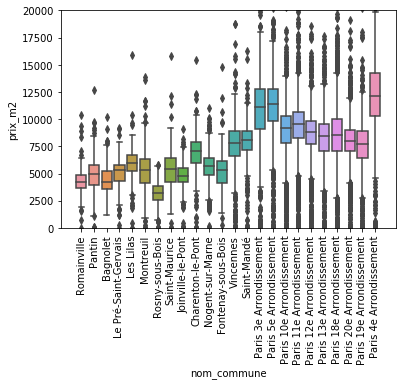

In [16]:
sns.boxplot(x="nom_commune", y="prix_m2", data=east_paris_transactions)
plt.ylim(0, 20000)
plt.xticks(rotation=90)
plt.autoscale(enable=True, axis='x')

So, depending on the cityes, median price go between **3000€/m²** and more than **12000€/m²**.

Let's take a look at the outliers, and simply drop them (prices per square meter above 20000€ or below 500€). The number of transactions we will keep per city is herebelow.

In [17]:
index_coll = east_paris_transactions[east_paris_transactions['prix_m2'] > 20000].index
index_coll = index_coll.append(east_paris_transactions[east_paris_transactions['prix_m2'] < 500].index)
east_paris_transactions = east_paris_transactions.drop(index_coll)
east_paris_transactions.reset_index(drop=True, inplace=True)
print(east_paris_transactions.shape)

east_paris_transactions.groupby(['code_postal', 'nom_commune'])['nombre_transactions'].sum()

(23367, 19)


code_postal  nom_commune             
75003        Paris 3e Arrondissement      760
75004        Paris 4e Arrondissement      524
75005        Paris 5e Arrondissement      824
75010        Paris 10e Arrondissement    1627
75011        Paris 11e Arrondissement    2561
75012        Paris 12e Arrondissement    1675
75013        Paris 13e Arrondissement    1576
75018        Paris 18e Arrondissement    3626
75019        Paris 19e Arrondissement    1829
75020        Paris 20e Arrondissement    2123
93100        Montreuil                   1035
93110        Rosny-sous-Bois              472
93170        Bagnolet                     312
93230        Romainville                  205
93260        Les Lilas                    275
93310        Le Pré-Saint-Gervais         198
93500        Pantin                       643
94120        Fontenay-sous-Bois           430
94130        Nogent-sur-Marne             572
94160        Saint-Mandé                  407
94220        Charenton-le-Pont            

#### To resume, we have now, in the dataframe east_paris_transactions the list of real estate transactions from 2018 in the cities of our choice, with the associated price / squere meter

#### This list contains approx. 23,000 transactions

### II.3 Divide geographical space in square tiles

Now let's analyse the geographical shape of our list of cities and divide this surface in a grid of 18x18 tiles.

In [18]:
bins_lat = np.linspace(min(east_paris_transactions['latitude']), max(east_paris_transactions['latitude']), 19)
lat_names = list(range(0,18))
east_paris_transactions['bins_lat'] = pd.cut(east_paris_transactions['latitude'], bins_lat, labels=lat_names, include_lowest=True)
bins_long = np.linspace(min(east_paris_transactions['longitude']), max(east_paris_transactions['longitude']), 19)
long_names = lat_names = list(range(0,18))
east_paris_transactions['bins_long'] = pd.cut(east_paris_transactions['longitude'], bins_long, labels=long_names, include_lowest=True)

east_paris_transactions.head()

id_mutation date_mutation nature_mutation  code_postal  nom_commune  \
0  2018-1195952    2018-01-03           Vente        93230  Romainville   
1  2018-1195953    2018-01-08           Vente        93500       Pantin   
2  2018-1195954    2018-01-05           Vente        93170     Bagnolet   
3  2018-1195955    2018-01-05           Vente        93500       Pantin   
4  2018-1195960    2018-01-05           Vente        93500       Pantin   

   adresse_numero   adresse_nom_voie  valeur_fonciere  longitude   latitude  \
0              25  BD EMILE GENEVOIX         230000.0   2.435743  48.881934   
1               4      RUE LAPEROUSE          90000.0   2.393240  48.900227   
2               2  RUE DES LORIETTES         222000.0   2.420057  48.872363   
3              31         RUE DELIZY         278000.0   2.408445  48.896071   
4             143     AV JEAN LOLIVE         695000.0   2.412250  48.893774   

   numero_disposition  surface_reelle_bati  Appartement  Dépendance  \
0                   2                 59.0            1           1   
1                   1                 40.0            1           0   
2                   1                 55.0            1           0   
3                   2                 52.0            1           1   
4                   3                107.0            1           2   

   Local industriel. commercial ou assimilé  Maison  \
0                                         0       0   
1                                         0       0   
2                                         0       0   
3                                         0       0   
4                                         0       0   

   nombre_pieces_principales  nombre_transactions      prix_m2 bins_lat  \
0                          3                    1  3898.305085       12   
1                          3                    1  2250.000000       15   
2                          3                    1  4036.363636       10   
3                          2                    1  5346.153846       14   
4                          5                    1  6495.327103       14   

  bins_long  
0        10  
1         6  
2         9  
3         8  
4         8

We will calculate now the average **price / square meter** and the **number of transactions** which occured in each tile.

In [19]:
tiles = east_paris_transactions.groupby(['bins_lat','bins_long'])['prix_m2'].mean().reset_index()
tiles.set_index(['bins_lat', 'bins_long'])

tiles2 = east_paris_transactions.groupby(['bins_lat','bins_long'])['nombre_transactions'].sum().reset_index()
tiles2.set_index(['bins_lat', 'bins_long'])

tiles= tiles.join(tiles2.set_index(['bins_lat', 'bins_long']), on=['bins_lat','bins_long'])
tiles = tiles.dropna().set_index(['bins_lat', 'bins_long']).reset_index()
tiles = tiles.astype({'nombre_transactions': 'int64'}, copy=False)
tiles.head()

bins_lat bins_long      prix_m2  nombre_transactions
0        0        12  5189.112510                    6
1        0        13  4731.721471                  131
2        0        14  4788.432368                   49
3        0        15  4262.313225                   14
4        1         1  8161.830850                   42

Let's enrich this tile list with the geographical information (latitude, longitude, square borders), and also the postal address in the center of each tile.

In [20]:
import time
#return a minimal address as a string from a raw location got from a geolocator
def get_address_from_geolocator (location):

    try:
        road = location['address']['road']
    except:
        try:
            road = location['address']['cycleway']
        except:
            try:
                road = location['address']['pedestrian']
            except:
                try:
                    road = location['address']['footway']
                except:
                    try:
                        road = location['address']['path']
                    except:
                        try:
                            road = location['address']['suburb']
                        except:
                            road = 'No road'
                            print('Warning, no road:', location)

    try:
        postcode = location['address']['postcode']
    except:
        postcode = 'No code'
        print('Warning, no code:',location)

    try:
        city = location['address']['city_district']
    except:
        try:
            city = location['address']['town']
        except:
            try:
                city = location['address']['city']
            except:
                city = 'No city'
                print('Warning, no city:', location)
            
    #   tiles.loc[i, 'tile_id'] = s
    address = "{}, {}, {}".format(road, postcode, city)
    return address

In [21]:
geolocator = Nominatim(user_agent="paris_exp")

for lat in range(0, 18):
    index_list = tiles[tiles['bins_lat']==lat].index
    for k in index_list:
        tiles.at[k, 'lat_s'] = bins_lat[lat]
        tiles.at[k, 'lat_n'] = bins_lat[lat+1]
        tiles.at[k, 'latitude'] = (bins_lat[lat] + bins_lat[lat+1])/2

for long in range(0, 18):
    index_list = tiles[tiles['bins_long']==long].index
    for k in index_list:
        tiles.at[k, 'long_w'] = bins_long[long]
        tiles.at[k, 'long_e'] = bins_long[long+1]
        tiles.at[k, 'longitude'] = (bins_long[long] + bins_long[long+1])/2

for i in tiles.index:
    s = "{:02d}_{:02d}".format (tiles.loc[i, 'bins_lat'], tiles.loc[i, 'bins_long'],)
    tiles.loc[i, 'tile_id'] = s
    for j in range(0, 5):
        try:
            time.sleep(1)
            location = geolocator.reverse((tiles.loc[i,'latitude'], tiles.loc[i,'longitude']))
            adr = get_address_from_geolocator(location.raw)
            break
        except:
            time.sleep(3)
            adr = ''
    tiles.loc[i, 'address'] = adr
    print(s, adr)
    
tiles.head()

00_12 Avenue Joffre, 94700, Maisons-Alfort
00_13 Rue du Maréchal Leclerc, 94410, Saint-Maurice
00_14 Villa de la Grotte, 94340, Joinville-le-Pont
00_15 Rue Diderot, 94500, Champigny-sur-Marne
01_01 Allée du Bardo, 75014, Paris 14e Arrondissement
01_02 Rue Gouthière, 75013, Paris 13e Arrondissement
01_03 Rue Gandon, 75013, Paris 13e Arrondissement
01_04 Avenue de la Porte d'Ivry, 75013, Paris 13e Arrondissement
01_07 Autoroute de l’Est, 94220, Charenton-le-Pont
01_08 Rue Saint-Pierre, 94220, Charenton-le-Pont
01_09 Rue Adrien Damalix, 94410, Saint-Maurice
01_10 Impasse Junot, 94410, Saint-Maurice
01_11 Route Nouvelle, 75012, Paris 12e Arrondissement
01_13 Autoroute de l’Est, 75012, Paris 12e Arrondissement
01_14 Rue du Port, 94340, Joinville-le-Pont
01_15 Boulevard de Polangis, 94340, Joinville-le-Pont
02_01 Avenue Reille, 75014, Paris 14e Arrondissement
02_02 Rue de Tolbiac, 75013, Paris 13e Arrondissement
02_03 Rue de Tolbiac, 75013, Paris 13e Arrondissement
02_04 Rue Albert, 75013, P

11_09 Rue de Noisy le Sec, 93260, Les Lilas
11_10 Rue Anatole France, 93170, Bagnolet
11_11 Boulevard Henri Barbusse, 93230, Romainville
11_12 Avenue du Docteur Fernand Lamaze, 93100, Montreuil
11_13 Allée Joyeuse, 93100, Montreuil
11_14 Allée des Myosotis, 93110, Rosny-sous-Bois
11_15 Boulevard Gabriel Péri, 93110, Rosny-sous-Bois
11_16 Rue des Berthauds, 93110, Rosny-sous-Bois
11_17 Impasse de l'Aubépine, 93110, Rosny-sous-Bois
12_00 Rue de Bruxelles, 75009, Paris 9e Arrondissement
12_01 Rue d'Orsel, 75018, Paris 18e Arrondissement
12_02 Rue Guy Patin, 75010, Paris 10e Arrondissement
12_03 Rue Philippe de Girard, 75010, Paris 10e Arrondissement
12_04 Quai de la Loire, 75019, Paris 19e Arrondissement
12_05 Rue André Dubois, 75019, Paris 19e Arrondissement
12_06 Rue de la Solidarité, 75019, Paris 19e Arrondissement
12_07 Rue Anatole France, 93310, Le Pré-Saint-Gervais
12_08 Rue Jules Auffret, 93310, Le Pré-Saint-Gervais
12_09 Rue Paul Langevin, 93260, Les Lilas
12_10 Sente de la Ferme,

bins_lat bins_long      prix_m2  nombre_transactions      lat_s      lat_n  \
0        0        12  5189.112510                    6  48.811961  48.817690   
1        0        13  4731.721471                  131  48.811961  48.817690   
2        0        14  4788.432368                   49  48.811961  48.817690   
3        0        15  4262.313225                   14  48.811961  48.817690   
4        1         1  8161.830850                   42  48.817690  48.823419   

    latitude    long_w    long_e  longitude tile_id  \
0  48.814826  2.446647  2.456692   2.451669   00_12   
1  48.814826  2.456692  2.466738   2.461715   00_13   
2  48.814826  2.466738  2.476783   2.471761   00_14   
3  48.814826  2.476783  2.486829   2.481806   00_15   
4  48.820555  2.336146  2.346191   2.341168   01_01   

                                           address  
0             Avenue Joffre, 94700, Maisons-Alfort  
1    Rue du Maréchal Leclerc, 94410, Saint-Maurice  
2     Villa de la Grotte, 94340, Joinville-le-Pont  
3          Rue Diderot, 94500, Champigny-sur-Marne  
4  Allée du Bardo, 75014, Paris 14e Arrondissement

Let's have a look of how these tiles map the list of cities and arrondissements we are interested in.

Prior, we will define a function **rectTile** which allows to create a json geometrical square object. Then, build a GeoJson file which contains the list of all our tiles.

In [22]:
def rectTile(tile_ids, long_w_list, long_e_list, lat_s_list, lat_n_list):
    
    tile_list=[]
    for tile_id, long_w, long_e, lat_s, lat_n,  in zip(tile_ids, long_w_list, long_e_list, lat_s_list, lat_n_list):
                 
        # print("tile_id ", tile_id)
        # return only relevant information for each nearby venue
        tile_list.append(
             {"type":"Feature",\
                "geometry":\
                  {"type":"Polygon",\
                     "coordinates":[[[long_w, lat_s],[long_w, lat_n],[long_e, lat_n],[long_e, lat_s]]]},\
                "properties":{"tile_id":tile_id}})
    return(tile_list)

east_tile_list = rectTile(tile_ids=tiles['tile_id'],
                                    long_w_list=tiles['long_w'],
                                    long_e_list=tiles['long_e'],
                                    lat_s_list=tiles['lat_s'],
                                    lat_n_list=tiles['lat_n']                                                                
                                  )

east_tiles = {"type":"FeatureCollection",\
"features": east_tile_list}

f = open('all_tiles.json', 'w')
json.dump(east_tiles, f)
f.close()

In [23]:
def paris_tiles (paris_map):
    workfile = r'all_tiles.json'
    print(workfile)

    folium.GeoJson(
        workfile
    ).add_to(paris_map)
    return (paris_map)

Now let's show the map, with the border of cities and the initial list of tiles we have built

In [24]:
paris_east_map = paris_east()

paris_east_map = paris_cities(paris_east_map)

paris_east_map = paris_tiles(paris_east_map)

paris_east_map

all_tiles.json


On the top of that, center the circles in which we will look for Foursquera venues. The optimal radius seems to be 370 meters. The centers of the circles are in the center of each tile. The circles are superposing a little bit. However, we can accept this, as this gives the venues in the proximity of each tile center. 

In [26]:
for lat, lon in zip(tiles['latitude'], tiles['longitude']):
    #print (lat, lon)
    folium.Circle([lat, lon], radius=400, color='blue', fill=False).add_to(paris_east_map)


In [27]:
paris_east_map  

Looks good, but it is a little bit clumsy :-(

### II.4 Foursquera

In [28]:
# The code was removed by Watson Studio for sharing.
CLIENT_ID = 'WRGTBGWVIWD1S0LLK0GRGEARWM2GBYEQ1QOP0PSIPNBJHOUT' # your Foursquare ID
CLIENT_SECRET = 'VALOPUUYGGEAIWKNIW5WVQRIIGYRO2EZJ0LOTKT1JDXXECKF' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

Now, let's get the venues for the list of tiles we have built

In [29]:
def getNearbyVenues(tile_ids, latitudes, longitudes, radius=400, LIMIT=100):
    
    venues_list=[]
    for tile_id, lat, lng in zip(tile_ids, latitudes, longitudes):
                 
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        #print(url)
        # make the GET request
        for j in range(0, 5):
            try:
                time.sleep(0.5) 
                results = requests.get(url).json()["response"]['groups'][0]['items']
                break
            except:
                 time.sleep(3)                    
        
        print("tile_id ", tile_id, ": ", len(results), " venues")
        # return only relevant information for each nearby venue
        venues_list.append([(
            tile_id,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['tile_id',
                  'Tile Latitude', 
                  'Tile Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

paris_east_venues = getNearbyVenues(tile_ids=tiles['tile_id'],
                                    latitudes=tiles['latitude'],
                                    longitudes=tiles['longitude']
                                  )
print(paris_east_venues.shape)
paris_east_venues.tail(20)

tile_id  00_12 :  3  venues
tile_id  00_13 :  7  venues
tile_id  00_14 :  4  venues
tile_id  00_15 :  0  venues
tile_id  01_01 :  12  venues
tile_id  01_02 :  12  venues
tile_id  01_03 :  33  venues
tile_id  01_04 :  13  venues
tile_id  01_07 :  8  venues
tile_id  01_08 :  4  venues
tile_id  01_09 :  4  venues
tile_id  01_10 :  1  venues
tile_id  01_11 :  4  venues
tile_id  01_13 :  6  venues
tile_id  01_14 :  7  venues
tile_id  01_15 :  4  venues
tile_id  02_01 :  14  venues
tile_id  02_02 :  54  venues
tile_id  02_03 :  74  venues
tile_id  02_04 :  34  venues
tile_id  02_05 :  16  venues
tile_id  02_06 :  22  venues
tile_id  02_07 :  16  venues
tile_id  02_08 :  10  venues
tile_id  02_09 :  6  venues
tile_id  02_13 :  4  venues
tile_id  02_14 :  4  venues
tile_id  02_15 :  2  venues
tile_id  03_01 :  15  venues
tile_id  03_02 :  52  venues
tile_id  03_03 :  11  venues
tile_id  03_04 :  30  venues
tile_id  03_05 :  33  venues
tile_id  03_06 :  28  venues
tile_id  03_07 :  6  venues
ti

tile_id  Tile Latitude  Tile Longitude  \
4404   15_06      48.900762        2.391396   
4405   15_06      48.900762        2.391396   
4406   15_07      48.900762        2.401442   
4407   15_07      48.900762        2.401442   
4408   15_07      48.900762        2.401442   
4409   15_07      48.900762        2.401442   
4410   15_07      48.900762        2.401442   
4411   15_08      48.900762        2.411487   
4412   15_08      48.900762        2.411487   
4413   16_06      48.906491        2.391396   
4414   16_06      48.906491        2.391396   
4415   16_06      48.906491        2.391396   
4416   16_06      48.906491        2.391396   
4417   16_07      48.906491        2.401442   
4418   16_07      48.906491        2.401442   
4419   16_07      48.906491        2.401442   
4420   16_07      48.906491        2.401442   
4421   17_08      48.912220        2.411487   
4422   17_08      48.912220        2.411487   
4423   17_08      48.912220        2.411487   

                                                  Venue  Venue Latitude  \
4404                                Place Auguste Baron       48.900572   
4405  Super Insolite - boutique en ligne de cadeaux ...       48.899533   
4406                                             MurMur       48.902748   
4407                                        Halle Papin       48.904150   
4408                                    La Cité Fertile       48.898687   
4409                                     RER Pantin [E]       48.897989   
4410                                  Arrêt Pantin Gare       48.897897   
4411                   Galerie Thaddaeus Ropac - Pantin       48.899350   
4412                                             Mimoza       48.899457   
4413                  Sidi bousaïd (cuisine tunisienne)       48.904839   
4414                                           Superlav       48.905455   
4415                                La Villa Mais d'Ici       48.906391   
4416                                          KIngooroo       48.907874   
4417                                        Halle Papin       48.904150   
4418                          Compagnie d'arc de Pantin       48.909057   
4419                                 le patio provencal       48.908628   
4420                                       Pantin Rugby       48.909736   
4421                             Parc Des Courtillières       48.912800   
4422                                 Boulangerie Louise       48.909757   
4423                        Pharmacie du pont de pierre       48.912543   

      Venue Longitude                Venue Category  
4404         2.387162                         Plaza  
4405         2.395620                     Gift Shop  
4406         2.401252                  Climbing Gym  
4407         2.400839         Performing Arts Venue  
4408         2.398871         General Entertainment  
4409         2.400438                 Train Station  
4410         2.400650                      Bus Stop  
4411         2.408075                   Art Gallery  
4412         2.409012                    Restaurant  
4413         2.392877      Mediterranean Restaurant  
4414         2.394582                    Laundromat  
4415         2.387434         Performing Arts Venue  
4416         2.395802  Theme Park Ride / Attraction  
4417         2.400839         Performing Arts Venue  
4418         2.401340          Gym / Fitness Center  
4419         2.397452             French Restaurant  
4420         2.402935            Athletics & Sports  
4421         2.412086                        Garden  
4422         2.412532                        Bakery  
4423         2.415753                      Pharmacy

How many venues do we have? We get more than 4400 venues, covering all our tile space.

A quick histogram will help to understand how many venues we have per tile.

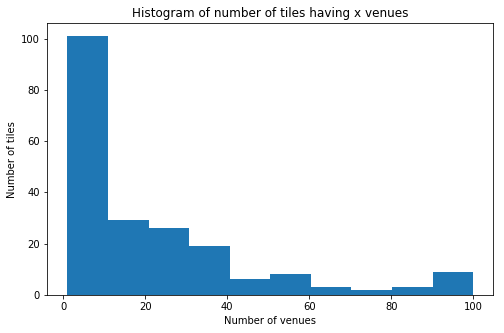

In [30]:
paris_east_venues['nombre_venues'] = 1
venues_per_tile = paris_east_venues.groupby(['tile_id','Tile Latitude', 'Tile Longitude'])['nombre_venues'].sum().reset_index()

# np.histogram returns 2 values
count, bin_edges = np.histogram(venues_per_tile['nombre_venues'])

#print(count) # frequency count
#print(bin_edges) # bin ranges, default = 10 bins

venues_per_tile['nombre_venues'].plot(kind='hist', figsize=(8, 5))

plt.title('Histogram of number of tiles having x venues') # add a title to the histogram
plt.ylabel('Number of tiles') # add y-label
plt.xlabel('Number of venues') # add x-label

plt.show()

So, there are approx. 100 tiles on our area, having a very small (less than 10) number of interesting venues.

Now let's add the number of venues to each tile of our **tiles** dataframe

In [31]:
tiles= tiles.join(venues_per_tile.set_index(['tile_id']), on=['tile_id'])
tiles.head()

bins_lat bins_long      prix_m2  nombre_transactions      lat_s      lat_n  \
0        0        12  5189.112510                    6  48.811961  48.817690   
1        0        13  4731.721471                  131  48.811961  48.817690   
2        0        14  4788.432368                   49  48.811961  48.817690   
3        0        15  4262.313225                   14  48.811961  48.817690   
4        1         1  8161.830850                   42  48.817690  48.823419   

    latitude    long_w    long_e  longitude tile_id  \
0  48.814826  2.446647  2.456692   2.451669   00_12   
1  48.814826  2.456692  2.466738   2.461715   00_13   
2  48.814826  2.466738  2.476783   2.471761   00_14   
3  48.814826  2.476783  2.486829   2.481806   00_15   
4  48.820555  2.336146  2.346191   2.341168   01_01   

                                           address  Tile Latitude  \
0             Avenue Joffre, 94700, Maisons-Alfort      48.814826   
1    Rue du Maréchal Leclerc, 94410, Saint-Maurice      48.814826   
2     Villa de la Grotte, 94340, Joinville-le-Pont      48.814826   
3          Rue Diderot, 94500, Champigny-sur-Marne            NaN   
4  Allée du Bardo, 75014, Paris 14e Arrondissement      48.820555   

   Tile Longitude  nombre_venues  
0        2.451669            3.0  
1        2.461715            7.0  
2        2.471761            4.0  
3             NaN            NaN  
4        2.341168           12.0

From the final list of tiles of interest, we will drop the tiles which have less than 20 real estate transactions and less than 4 venues per tile.

In [32]:
tiles.replace({'nombre_venues': np.NaN}, value=0, inplace=True)
tiles = tiles.astype({'nombre_venues': 'int64'}, copy=False)
index_coll = tiles[tiles['nombre_transactions']<20].index
tiles=tiles.drop(index_coll)
tiles.reset_index(drop=True, inplace=True)
index_coll = tiles[tiles['nombre_venues']<4].index
tiles=tiles.drop(index_coll)
tiles.reset_index(drop=True, inplace=True)
print (tiles.shape)
tiles.head()

(151, 15)


bins_lat bins_long      prix_m2  nombre_transactions      lat_s      lat_n  \
0        0        13  4731.721471                  131  48.811961  48.817690   
1        0        14  4788.432368                   49  48.811961  48.817690   
2        1         1  8161.830850                   42  48.817690  48.823419   
3        1         2  7737.428188                   52  48.817690  48.823419   
4        1         3  7066.006600                  112  48.817690  48.823419   

    latitude    long_w    long_e  longitude tile_id  \
0  48.814826  2.456692  2.466738   2.461715   00_13   
1  48.814826  2.466738  2.476783   2.471761   00_14   
2  48.820555  2.336146  2.346191   2.341168   01_01   
3  48.820555  2.346191  2.356237   2.351214   01_02   
4  48.820555  2.356237  2.366282   2.361259   01_03   

                                           address  Tile Latitude  \
0    Rue du Maréchal Leclerc, 94410, Saint-Maurice      48.814826   
1     Villa de la Grotte, 94340, Joinville-le-Pont      48.814826   
2  Allée du Bardo, 75014, Paris 14e Arrondissement      48.820555   
3   Rue Gouthière, 75013, Paris 13e Arrondissement      48.820555   
4      Rue Gandon, 75013, Paris 13e Arrondissement      48.820555   

   Tile Longitude  nombre_venues  
0        2.461715              7  
1        2.471761              4  
2        2.341168             12  
3        2.351214             12  
4        2.361259             33

Our **tiles** dataframe contains now a list of 151 geographical square zones (tiles), with the **average price per square meter**, the number of real estate transactions and the **number of venues** of interest for each tile

### II.5 Show real estate and number of venues on the same map

Our final part of the data analysis is to figure out - on the same map:
    - the average price per square meter
    - the number of venues
for all the tiles which cover our interest area

Let's rebuild our **east_tile_list** and generate a GeoJson file coresponding to the list of tiles of interest

In [33]:
east_tile_list = rectTile(tile_ids=tiles['tile_id'],
                                    long_w_list=tiles['long_w'],
                                    long_e_list=tiles['long_e'],
                                    lat_s_list=tiles['lat_s'],
                                    lat_n_list=tiles['lat_n']                                                                
                                  )

east_tile_list
east_tiles = {"type":"FeatureCollection",\
"features": east_tile_list}

f = open('east_tiles.json', 'w')

json.dump(east_tiles, f)

f.close()

Using a choropleth map, we will show the averag price per square meter in the various zones of interest

In [34]:
def paris_price_m2 (paris_map):

    workfile = r'east_tiles.json'
    print(workfile)

    folium.GeoJson(
        workfile
    ).add_to(paris_map)


    paris_map.choropleth(
        geo_data=workfile,
        data=tiles,
        columns=['tile_id', 'prix_m2'],
        key_on='feature.properties.tile_id',
        fill_color='YlOrRd', 
        fill_opacity=0.5, 
        line_opacity=0.2,
        legend_name='Real Estate price per square meter'
    )

    return paris_map

On the top of this we will add circle markers. The radius will represent the number of venues available in the tile (with a maximum of 100)

In [35]:
paris_east_map = paris_east()
paris_east_map = paris_price_m2 (paris_east_map)

# set color scheme for the clusters
x = np.arange(0,100)
ys = [i + x + (i*x)**2 for i in range(0,100)]


for lat, lng, nbv, nbt, prix in zip(tiles['Tile Latitude'], tiles['Tile Longitude'], tiles['nombre_venues'], tiles['nombre_transactions'], tiles['prix_m2']):
    label = '{:.0f} €/m2, {} transactions, {} venues'.format(prix, nbt, nbv)
#    print(label)
    folium.CircleMarker(
        [lat, lng],
        radius=3+12*(nbv/100), # define how big you want the circle markers to be
       color='Blue', 
        fill=True,
       popup=label,
        fill_color='Blue',
        fill_opacity=0.5
).add_to(paris_east_map)   

paris_east_map

east_tiles.json


As a first conclusion of this Data Analysis section, it seems that we have a **direct correlation** beteween the **real estate price per square meter** in a zone and the **number of venues on interest** in the same region.

A more detailed analysis will follow in the next sections

## III. Methodology <a name="methodology"></a>

In this project we try to find if there is a **correlation** between the real estate prices and the type of interest venues in the neighbourhood. We will try to describe what is the **venue segment associated with a "expensive", "medium" and "low price" neighborhood**.

We will than use then our data science powers to make some recommendation for the Mayor in order to adjust the City Policies. Particularly, we will try to find **what kind of venues** should be encouraged in order to increase the **attractiveness of the low price neighborhoods**.

As a first step we have collected the required data:
- we have defined a list of geographical zones, represented as tiles, for which we have calculated the average real estate price for apprtments;
- for each tile, we have collected also the number and the categories of venues of interest (according to Foursquare categorization).

In the second step in our analysis we will perform three correlation approaches:
- first we will do a simple linear regression between the number of interest venues in a tile and the average real estate prices of the appartments;
- second, we will segment the tiles according to the type of venues present in each one; we will try to identify the segments associated with low, medium and high price neighbourhoods;
- third, we will perform a multiple linear regression between the detailed type of venues and the real estate price in each tile.

Finaly, after scoring each approach, we will try to identify the precise segments or categories of venues whith a strong positive correlation with the real estate prices. The associated City policies will be to encourage the implantation of those type of venues which increase the attractivity of each neighboourhood.

## IV. Analysis <a name="analysis"></a>

### IV.1 Simple linear regression

Let's perform a simple linear rergression between the number of venues of interest and the real estate price per square meter associated to each tile.

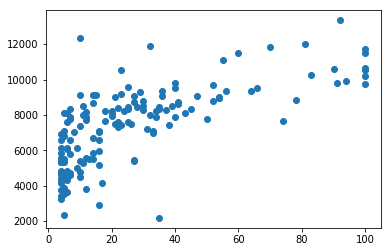

In [36]:
plt.scatter(x=tiles['nombre_venues'], y=tiles['prix_m2'])
plt.show()

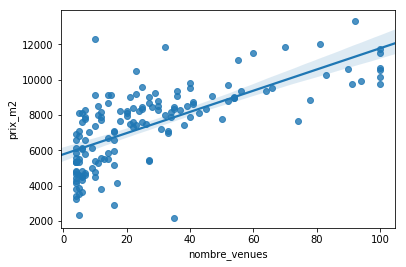

In [37]:
sns.regplot(x=tiles['nombre_venues'], y=tiles['prix_m2'])

We will use the basic LinearRegression model and measure its performance using the variance score

In [38]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
x = np.asanyarray(tiles[['nombre_venues']])
y = np.asanyarray(tiles[['prix_m2']])

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=4)

regr.fit (x_train, y_train)

# The coefficients
print ('Coefficients: ', regr.coef_)
print ('Intercept: ', regr.intercept_)
print('Variance score train set: %.2f' % regr.score(x_train, y_train))
print('Variance score test set: %.2f' % regr.score(x_test, y_test))

Coefficients:  [[60.92106404]]
Intercept:  [5687.3677359]
Variance score train set: 0.47
Variance score test set: 0.51


We get and **variance score of 0.51** which shows a **weak positive correlation** between the number of venues of interest and the price per square meters of the appartments in each tile.

### IV.2 Segment the venues per tile

The second type of analysis will be to segment and cluster the tiles, based on the categories of venues present in each tile.

Let's see how many different categories do we have:

In [39]:
ven_cat = paris_east_venues.groupby(['Venue Category'])['nombre_venues'].sum().reset_index()
print(ven_cat.shape)
ven_cat.head()

(324, 2)


Venue Category  nombre_venues
0    Accessories Store              3
1    Afghan Restaurant              1
2   African Restaurant             16
3  Alsatian Restaurant              2
4  American Restaurant              8

Let's calculate how many venues - per category - do we have in each tile. We will use "one hot" encoding

In [40]:
# one hot encoding
venues_onehot = pd.get_dummies(paris_east_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
venues_onehot['tile_id'] = paris_east_venues['tile_id'] 

# move neighborhood column to the first column
fixed_columns = [venues_onehot.columns[-1]] + list(venues_onehot.columns[:-1])
venues_onehot = venues_onehot[fixed_columns]

print(venues_onehot.shape)
venues_onehot.head()

(4424, 325)


tile_id  Accessories Store  Afghan Restaurant  African Restaurant  \
0   00_12                  0                  0                   0   
1   00_12                  0                  0                   0   
2   00_12                  0                  0                   0   
3   00_13                  0                  0                   0   
4   00_13                  0                  0                   0   

   Alsatian Restaurant  American Restaurant  Aquarium  Arepa Restaurant  \
0                    0                    0         0                 0   
1                    0                    0         0                 0   
2                    0                    0         0                 0   
3                    0                    0         0                 0   
4                    0                    0         0                 0   

   Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                       0            0           0                    0   
1                       0            0           0                    0   
2                       0            0           0                    0   
3                       0            0           0                    0   
4                       0            0           0                    0   

   Asian Restaurant  Athletics & Sports  Auto Dealership  Auto Garage  \
0                 0                   0                0            0   
1                 0                   0                0            0   
2                 0                   0                0            0   
3                 0                   0                0            0   
4                 0                   0                0            0   

   Auto Workshop  Automotive Shop  Auvergne Restaurant  BBQ Joint  Baby Store  \
0              0                0                    0          0           0   
1              0                0                    0          0           0   
2              0                0                    0          0           0   
3              0                0                    0          0           0   
4              0                0                    0          0           0   

   Bagel Shop  Bakery  Bar  Baseball Stadium  Basketball Court  \
0           0       1    0                 0                 0   
1           0       0    0                 0                 0   
2           0       0    0                 0                 0   
3           0       0    0                 0                 0   
4           0       0    0                 0                 0   

   Basque Restaurant  Beach  Bed & Breakfast  Beer Bar  Beer Garden  \
0                  0      0                0         0            0   
1                  0      0                0         0            0   
2                  0      0                0         0            0   
3                  0      0                0         0            0   
4                  0      0                0         0            0   

   Beer Store  Big Box Store  Bike Rental / Bike Share  Bistro  \
0           0              0                         0       0   
1           0              0                         0       0   
2           0              0                         0       0   
3           0              0                         0       0   
4           0              0                         0       0   

   Boarding House  Boat or Ferry  Bookstore  Botanical Garden  Boutique  \
0               0              0          0                 0         0   
1               0              0          0                 0         0   
2               0              0          0                 0         0   
3               0              0          0                 0         0   
4               0              0          0                 0         0   

   Bowling Alley  Boxing Gym  Brasserie  Brazilian Restaurant  Breakfast Sp

In [41]:
venues_grouped_sum = venues_onehot.groupby('tile_id').sum().reset_index()
venues_grouped_sum.head(10)

tile_id  Accessories Store  Afghan Restaurant  African Restaurant  \
0   00_12                  0                  0                   0   
1   00_13                  0                  0                   0   
2   00_14                  0                  0                   0   
3   01_01                  0                  0                   0   
4   01_02                  0                  0                   0   
5   01_03                  0                  0                   0   
6   01_04                  0                  0                   0   
7   01_07                  0                  0                   0   
8   01_08                  0                  0                   0   
9   01_09                  0                  0                   0   

   Alsatian Restaurant  American Restaurant  Aquarium  Arepa Restaurant  \
0                    0                    0         0                 0   
1                    0                    0         0                 0   
2                    0                    0         0                 0   
3                    0                    0         0                 0   
4                    0                    0         0                 0   
5                    0                    0         0                 0   
6                    0                    0         0                 0   
7                    0                    0         0                 0   
8                    0                    0         0                 0   
9                    0                    0         0                 0   

   Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                       0            0           0                    0   
1                       0            0           0                    0   
2                       0            0           0                    0   
3                       0            0           0                    0   
4                       0            0           0                    0   
5                       0            0           0                    0   
6                       0            0           0                    0   
7                       0            0           0                    0   
8                       0            0           0                    0   
9                       0            0           0                    0   

   Asian Restaurant  Athletics & Sports  Auto Dealership  Auto Garage  \
0                 0                   0                0            0   
1                 0                   0                0            0   
2                 0                   0                0            0   
3                 0                   0                0            0   
4                 0                   0                0            0   
5                 5                   0                0            0   
6                 0                   0                0            0   
7                 0                   0                0            0   
8                 0                   0                0            0   
9                 1                   0                0            0   

   Auto Workshop  Automotive Shop  Auvergne Restaurant  BBQ Joint  Baby Store  \
0              0                0                    0          0           0   
1              0                0                    0          0           0   
2              0                0                    0          0           0   
3              0                0                    0          0           0   
4              0                0                    0          0           0   
5              0                0                    0          0           0   
6              0                0                    0          0           0   
7              0                0                    0          0           0   
8              0                0  

Now let's find which are the 15 more common venues associated to each tile.

In [42]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    row_categories_names = row_categories_sorted.index.values[0:num_top_venues]
    for k in range(0, num_top_venues):
        if row_categories_sorted[k] == 0:
            row_categories_names[k] = ''
        else:
            row_categories_names[k] = "{:.2f} {}".format(row_categories_sorted[k], row_categories_names[k])

    #print (row_categories_names)    
    
    return row_categories_names[0:num_top_venues]

In [43]:
num_top_venues = 15

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['tile_id', 'Cluster Labels']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
tiles_venues_sorted = pd.DataFrame(columns=columns)
tiles_venues_sorted['tile_id'] = venues_grouped_sum['tile_id']

for ind in np.arange(venues_grouped_sum.shape[0]):
    tiles_venues_sorted.iloc[ind, 2:] = return_most_common_venues(venues_grouped_sum.iloc[ind, :], num_top_venues)

tiles_venues_sorted.head(10)

tile_id Cluster Labels       1st Most Common Venue    2nd Most Common Venue  \
0   00_12            NaN               1.00 Pharmacy   1.00 French Restaurant   
1   00_13            NaN                 1.00 Bakery               1.00 Hotel   
2   00_14            NaN                 1.00 Market            1.00 Creperie   
3   01_01            NaN                   2.00 Park              1.00 Bakery   
4   01_02            NaN                  2.00 Plaza  1.00 Chinese Restaurant   
5   01_03            NaN  6.00 Vietnamese Restaurant  5.00 Chinese Restaurant   
6   01_04            NaN                  2.00 Hotel     1.00 Bed & Breakfast   
7   01_07            NaN        1.00 Thai Restaurant               1.00 Hotel   
8   01_08            NaN                1.00 Stadium           1.00 Laser Tag   
9   01_09            NaN       1.00 Asian Restaurant  1.00 Italian Restaurant   

        3rd Most Common Venue     4th Most Common Venue  \
0                 1.00 Bakery                             
1            1.00 Gas Station  1.00 Japanese Restaurant   
2      1.00 French Restaurant           1.00 Playground   
3  1.00 Vietnamese Restaurant         1.00 Squash Court   
4       1.00 Football Stadium                 1.00 Café   
5       5.00 Asian Restaurant      3.00 Thai Restaurant   
6            1.00 Rugby Pitch          1.00 Supermarket   
7   1.00 Caribbean Restaurant  1.00 Japanese Restaurant   
8            1.00 Supermarket               1.00 Market   
9            1.00 Pizza Place          1.00 Supermarket   

            5th Most Common Venue      6th Most Common Venue  \
0                                                              
1                1.00 Pizza Place  1.00 Gym / Fitness Center   
2                                                              
3  1.00 Middle Eastern Restaurant     1.00 French Restaurant   
4                     1.00 Garden                 1.00 Diner   
5       3.00 Cantonese Restaurant  2.00 Cambodian Restaurant   
6            1.00 Thai Restaurant    1.00 Chinese Restaurant   
7                  1.00 Laser Tag              1.00 Bus Stop   
8                                                              
9                                                              

        7th Most Common Venue 8th Most Common Venue    9th Most Common Venue  \
0                                                                              
1                  1.00 Plaza                                                  
2                                                                              
3               1.00 Bus Stop          1.00 Theater  1.00 Chinese Restaurant   
4               1.00 Bus Stop     1.00 Tram Station         1.00 Pizza Place   
5                 1.00 Lounge             1.00 Café       1.00 Shopping Mall   
6  1.00 Vietnamese Restaurant          1.00 Stadium   1.00 Food & Drink Shop   
7                 1.00 Lounge        1.00 Cafeteria                            
8                                                                              
9                                                                              

  10th Most Common Venue 11th Most Common Venue     12th Most Common Venue  \
0                                                                            
1                                                                            
2                                                                            
3         1.00 Brasserie               1.00 Pub                              
4              1.00 Park           1.00 Stadium                              
5     1.00 Grocery Store       1.00 Supermarket  1.00 Gym / Fitness Center   
6     1.00 Shopping Mall       1.00 Coffee Shop          1.00 Tram Station   
7                                                                            
8                                                                            
9                                                                            

  13th Most Com

We will now use the KMeans algorithm in order to segment the tiles in 12 different clusters. 

Segmentation will be done based on the number of venues per category present in each tile. We will not normalize data, as each tile has a maximum number of 100 venues (number of venues is already normalized).

In [46]:
# set number of clusters
kclusters = 12

tiles_grouped_clustering = venues_grouped_sum.drop('tile_id', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(tiles_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:200] 

array([ 6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  4,
        2,  5,  6,  0,  0,  6,  6,  6,  6,  6,  0,  5,  6,  5,  0,  0,  6,
        6,  6,  6,  6,  6,  6,  5,  3,  0,  6,  5,  5,  5,  6,  6,  6,  6,
        6,  5,  8,  6,  9,  5,  0,  0,  6,  0,  5,  6,  6,  6,  6,  6,  6,
        8,  3,  6,  5, 10,  4,  5,  0,  5,  0,  0,  6,  6,  6,  6,  6,  1,
        3, 10,  1,  1,  5,  4,  0,  0,  6,  6,  6,  6,  6,  6,  0,  8,  5,
        5,  5,  5,  5,  6,  6,  6,  0,  6,  6,  6,  6,  6,  6,  7,  1,  1,
       11,  4,  4,  0,  0,  6,  6,  6,  6,  6,  6,  6,  6,  4,  8,  5,  4,
        4,  0,  6,  6,  6,  6,  6,  6,  6,  6,  6, 10,  5,  4,  5,  0,  6,
        0,  6,  6,  6,  6,  6,  6,  6,  6, 10,  3,  6,  0,  0,  5,  6,  0,
        6,  6,  6,  6,  6,  6, 10, 10,  4,  5,  6,  5,  0,  6,  6,  6,  6,
        6,  0,  0,  6,  0,  5,  5,  6,  6,  6,  6,  6,  6], dtype=int32)

We will now associated a cluster label to each tile. Labels are from 0 to 11.

In [47]:
# add clustering labels
#tiles_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
tiles_venues_sorted['Cluster Labels'] = kmeans.labels_

tiles_merged = tiles
# merge tiles_merged with tiles_venues_sorted to add latitude/longitude for Cluster and most common venues for each tile
tiles_merged = tiles_merged.join(tiles_venues_sorted.set_index('tile_id'), on='tile_id')
tiles_merged.head(10) # check the last columns!

bins_lat bins_long      prix_m2  nombre_transactions      lat_s      lat_n  \
0        0        13  4731.721471                  131  48.811961  48.817690   
1        0        14  4788.432368                   49  48.811961  48.817690   
2        1         1  8161.830850                   42  48.817690  48.823419   
3        1         2  7737.428188                   52  48.817690  48.823419   
4        1         3  7066.006600                  112  48.817690  48.823419   
5        1         4  5481.023307                   36  48.817690  48.823419   
6        1         8  6578.647566                  155  48.817690  48.823419   
7        1         9  6919.046132                  138  48.817690  48.823419   
8        1        13  4854.089458                   52  48.817690  48.823419   
9        1        14  4590.760418                   34  48.817690  48.823419   

    latitude    long_w    long_e  longitude tile_id  \
0  48.814826  2.456692  2.466738   2.461715   00_13   
1  48.814826  2.466738  2.476783   2.471761   00_14   
2  48.820555  2.336146  2.346191   2.341168   01_01   
3  48.820555  2.346191  2.356237   2.351214   01_02   
4  48.820555  2.356237  2.366282   2.361259   01_03   
5  48.820555  2.366282  2.376328   2.371305   01_04   
6  48.820555  2.406464  2.416510   2.411487   01_08   
7  48.820555  2.416510  2.426556   2.421533   01_09   
8  48.820555  2.456692  2.466738   2.461715   01_13   
9  48.820555  2.466738  2.476783   2.471761   01_14   

                                             address  Tile Latitude  \
0      Rue du Maréchal Leclerc, 94410, Saint-Maurice      48.814826   
1       Villa de la Grotte, 94340, Joinville-le-Pont      48.814826   
2    Allée du Bardo, 75014, Paris 14e Arrondissement      48.820555   
3     Rue Gouthière, 75013, Paris 13e Arrondissement      48.820555   
4        Rue Gandon, 75013, Paris 13e Arrondissement      48.820555   
5  Avenue de la Porte d'Ivry, 75013, Paris 13e Ar...      48.820555   
6         Rue Saint-Pierre, 94220, Charenton-le-Pont      48.820555   
7           Rue Adrien Damalix, 94410, Saint-Maurice      48.820555   
8  Autoroute de l’Est, 75012, Paris 12e Arrondiss...      48.820555   
9              Rue du Port, 94340, Joinville-le-Pont      48.820555   

   Tile Longitude  nombre_venues  Cluster Labels       1st Most Common Venue  \
0        2.461715              7               6                 1.00 Bakery   
1        2.471761              4               6                 1.00 Market   
2        2.341168             12               6                   2.00 Park   
3        2.351214             12               6                  2.00 Plaza   
4        2.361259             33               6  6.00 Vietnamese Restaurant   
5        2.371305             13               6                  2.00 Hotel   
6        2.411487              4               6                1.00 Stadium   
7        2.421533              4               6       1.00 Asian Restaurant   
8        2.461715              6               6                1.00 Stadium   
9        2.471761              7               6       1.00 Sushi Restaurant   

     2nd Most Common Venue       3rd Most Common Venue  \
0               1.00 Hotel            1.00 Gas Station   
1            1.00 Creperie      1.00 French Restaurant   
2              1.00 Bakery  1.00 Vietnamese Restaurant   
3  1.00 Chinese Restaurant       1.00 Football Stadium   
4  5.00 Chinese Restaurant       5.00 Asian Restaurant   
5     1.00 Bed & Breakfast            1.00 Rugby Pitch   
6           1.00 Laser Tag            1.00 Supermarket   
7  1.00 Italian Restaurant            1.00 Pizza Place   
8       1.00 Train Station            1.00 Supermarket   
9               1.00 Hotel   1.00 Fast Food Restaurant   

      4th Most Common Venue           5th Most Common Venue  \
0  1.00 Japanese Restaurant                1.00 Pizza Place   
1           1.00 Playground                                   
2         1.00 Squash Co

We will now calculate the average number of venues for tiles belonging the same cluster.

Than we will reorder the cluster labels according to the average number of venues. New names of label clusters are shown below

In [50]:
venues_grouped_cluster = venues_grouped_sum
venues_grouped_cluster = venues_grouped_cluster.join(tiles_merged[['tile_id', 'Cluster Labels', 'nombre_venues']].set_index('tile_id'), on='tile_id')
venues_grouped_cluster = venues_grouped_cluster.dropna().reset_index(drop=True)
venues_grouped_cluster = venues_grouped_cluster.astype({'Cluster Labels': 'int64'}, copy=False)
venues_grouped_cluster = venues_grouped_cluster.astype({'nombre_venues': 'int64'}, copy=False)
venues_grouped_cluster.head(10)

cluster_grouped_mean = venues_grouped_cluster.drop('tile_id',1).groupby('Cluster Labels').mean().reset_index()

cluster_labels_sorted = cluster_grouped_mean[['Cluster Labels', 'nombre_venues']].sort_values(['nombre_venues']).reset_index(drop=True)

dict_cluster_rename = dict(zip(cluster_labels_sorted['Cluster Labels'], cluster_labels_sorted.index ))
dict_cluster_rename

{6: 0, 0: 1, 5: 2, 4: 3, 9: 4, 10: 5, 8: 6, 2: 7, 11: 8, 3: 9, 1: 10, 7: 11}

We change the label of the clusters. The 12 clusters, with their average number of venues per category are shown below:

In [51]:
venues_grouped_cluster['Cluster Labels'].replace(to_replace=dict_cluster_rename, inplace=True)
tiles_venues_sorted['Cluster Labels'].replace(to_replace=dict_cluster_rename, inplace=True)
tiles_merged['Cluster Labels'].replace(to_replace=dict_cluster_rename, inplace=True)

cluster_grouped_mean['Cluster Labels'].replace(to_replace=dict_cluster_rename, inplace=True)
cluster_grouped_mean = cluster_grouped_mean.sort_values(['Cluster Labels']).reset_index(drop=True)
cluster_grouped_mean

Cluster Labels  Accessories Store  Afghan Restaurant  African Restaurant  \
0                0                0.0           0.000000            0.029412   
1                1                0.0           0.000000            0.125000   
2                2                0.0           0.038462            0.153846   
3                3                0.0           0.000000            0.100000   
4                4                0.0           0.000000            0.000000   
5                5                0.0           0.000000            0.166667   
6                6                0.0           0.000000            0.250000   
7                7                0.0           0.000000            0.000000   
8                8                0.0           0.000000            2.000000   
9                9                0.0           0.000000            0.000000   
10              10                0.2           0.000000            0.200000   
11              11                0.0           0.000000            1.000000   

    Alsatian Restaurant  American Restaurant  Aquarium  Arepa Restaurant  \
0                  0.00             0.014706  0.014706          0.000000   
1                  0.00             0.041667  0.000000          0.000000   
2                  0.00             0.115385  0.000000          0.000000   
3                  0.00             0.100000  0.000000          0.000000   
4                  0.00             0.000000  0.000000          0.000000   
5                  0.00             0.333333  0.000000          0.166667   
6                  0.25             0.000000  0.000000          0.000000   
7                  0.00             0.000000  0.000000          0.000000   
8                  0.00             0.000000  0.000000          0.000000   
9                  0.25             0.000000  0.000000          0.000000   
10                 0.00             0.000000  0.000000          0.000000   
11                 0.00             0.000000  0.000000          0.000000   

    Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                 0.000000     0.029412    0.000000             0.000000   
1                 0.000000     0.000000    0.000000             0.000000   
2                 0.038462     0.153846    0.115385             0.076923   
3                 0.000000     0.100000    0.000000             0.100000   
4                 0.000000     0.000000    0.000000             0.000000   
5                 0.166667     0.666667    0.500000             0.000000   
6                 0.000000     0.750000    0.250000             0.250000   
7                 0.000000     0.000000    0.000000             0.000000   
8                 0.000000     0.000000    0.000000             0.000000   
9                 0.000000     0.250000    0.500000             0.250000   
10                0.200000     1.000000    0.000000             0.400000   
11                0.000000     0.000000    0.000000             0.000000   

    Asian Restaurant  Athletics & Sports  Auto Dealership  Auto Garage  \
0           0.161765            0.000000         0.000000     0.014706   
1           0.041667            0.041667         0.041667     0.000000   
2           0.615385            0.000000         0.000000     0.000000   
3           0.100000            0.000000         0.000000     0.000000   
4           0.000000            0.000000         0.000000     0.000000   
5           0.166667            0.000000         0.000000     0.000000   
6           0.750000            0.000000         0.000000     0.000000   
7          12.000000            0.000000         0.000000     0.000000   
8           1.000000            0.000000         0.000000     0.000000   
9           0.250000            0.000000         0.000000     0.000000   
10          0.800000            0.000000         0.000000     0.000000   
11          1.000000            0.000000         0.000000     0.000000   

    Auto Workshop  Aut

Now let's show our map with the 3 informations associated to each tile:
- the average price per square meter (the choropleth colour of each tile)
- the number of venues per tile, represented by the size of the circle marker
- the segment of the tile, represented by the colour of each circle marker.

In [52]:
paris_east_map = paris_east()
paris_east_map = paris_price_m2 (paris_east_map)


# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, cluster, nbv in zip(tiles_merged['Tile Latitude'], tiles_merged['Tile Longitude'], tiles_merged['Cluster Labels'], tiles_merged['nombre_venues']):
    label = 'Cluster C{}; Nb_venues: {}'.format(cluster, nbv)
    folium.CircleMarker(
        [lat, lon],
        radius=3+12*(nbv/100), # define how big you want the circle markers to be
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7
        ).add_to(paris_east_map)
       
paris_east_map

east_tiles.json


Let's take a look at the most common venues for each segment:

In [53]:
num_top_venues = 15

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Cluster Labels', 'Total venues']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
cluster_venues_sorted = pd.DataFrame(columns=columns)
cluster_venues_sorted['Cluster Labels'] = cluster_grouped_mean['Cluster Labels']
cluster_venues_sorted['Total venues'] = cluster_grouped_mean['nombre_venues']
print(cluster_venues_sorted.shape)

for ind in np.arange(cluster_grouped_mean.shape[0]):
   cluster_venues_sorted.iloc[ind, 2:] = return_most_common_venues(cluster_grouped_mean.iloc[ind, :-1], num_top_venues)

cluster_venues_sorted.head(12)

(12, 17)


Cluster Labels  Total venues        1st Most Common Venue  \
0                0      8.529412             0.44 Supermarket   
1                1     19.666667       1.62 French Restaurant   
2                2     32.807692       3.73 French Restaurant   
3                3     44.300000                     6.00 Bar   
4                4     54.000000                  11.00 Hotel   
5                5     59.833333      11.83 French Restaurant   
6                6     70.500000       7.75 French Restaurant   
7                7     74.000000  17.00 Vietnamese Restaurant   
8                8     78.000000                    21.00 Bar   
9                9     82.250000      16.00 French Restaurant   
10              10     98.200000      14.00 French Restaurant   
11              11    100.000000            9.00 Cocktail Bar   

     2nd Most Common Venue    3rd Most Common Venue     4th Most Common Venue  \
0   0.37 French Restaurant               0.29 Hotel                0.24 Plaza   
1               1.46 Hotel         1.08 Supermarket               1.04 Bakery   
2               2.23 Hotel                 1.35 Bar   1.35 Italian Restaurant   
3   5.10 French Restaurant              1.70 Bistro                 1.60 Café   
4      6.00 Sandwich Place   5.00 French Restaurant            4.00 Nightclub   
5               4.00 Hotel  4.00 Italian Restaurant               2.00 Bakery   
6               3.25 Hotel         3.25 Coffee Shop               2.75 Bakery   
7   12.00 Asian Restaurant     9.00 Thai Restaurant    4.00 French Restaurant   
8          3.00 Restaurant         3.00 Pizza Place  2.00 Japanese Restaurant   
9                4.25 Café              3.50 Bakery   3.25 Italian Restaurant   
10                5.40 Bar               4.20 Hotel               4.20 Bistro   
11  6.00 French Restaurant            6.00 Wine Bar               6.00 Bakery   

             5th Most Common Venue     6th Most Common Venue  \
0                 0.22 Pizza Place             0.21 Bus Stop   
1                        0.71 Café  0.67 Japanese Restaurant   
2                      1.15 Bistro                 1.15 Café   
3                      1.50 Bakery          1.50 Pizza Place   
4                      3.00 Bakery             2.00 Beer Bar   
5                         1.83 Bar             1.50 Wine Bar   
6                         2.25 Bar                 2.25 Café   
7                 4.00 Supermarket   4.00 Chinese Restaurant   
8   2.00 Middle Eastern Restaurant              2.00 Brewery   
9                       3.00 Hotel                2.75 Plaza   
10                   3.00 Wine Bar   2.80 Italian Restaurant   
11                      5.00 Hotel          4.00 Coffee Shop   

   7th Most Common Venue     8th Most Common Venue  \
0              0.19 Park                 0.19 Café   
1               0.62 Bar                0.58 Plaza   
2        1.04 Restaurant  0.96 Japanese Restaurant   
3             1.30 Hotel           1.30 Restaurant   
4         2.00 Hotel Bar         2.00 Cocktail Bar   
5             1.33 Plaza          1.33 Pizza Place   
6             2.00 Plaza             1.75 Creperie   
7              2.00 Café          2.00 Pastry Shop   
8            2.00 Lounge            2.00 Nightclub   
9              2.50 Park          2.25 Coffee Shop   
10      2.60 Pizza Place           2.60 Restaurant   
11  4.00 Thai Restaurant   4.00 Italian Restaurant   

         9th Most Common Venue      10th Most Common Venue  \
0   0.18 Vietnamese Restaurant     0.18 Chinese Restaurant   
1             0.54 Pizza Place      0.46 Indian Restaurant   
2             0.88 Coffee Shop                 0.85 Bakery   
3     1.30 Japanese Restaurant  1.00 Vietnamese Restaurant   
4             2.00 Coffee Shop         1.00 Cosmetics Shop   
5             1.33 Coffee Shop             1.17 Restaurant   
6               1.50 Bookstore                 1.50 Bistro   
7                  2.00 Bakery              2.00 Juice Bar   
8         

Let's see if we can find a correlation between the average price per square meter and the cluster id. A bloxplot will help:

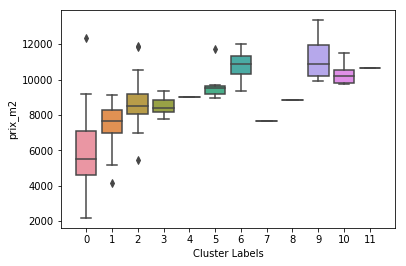

In [54]:
sns.boxplot(x="Cluster Labels", y="prix_m2", data=tiles_merged)
plt.autoscale(enable=True, axis='x')

Now let's figure out if we see a linear relationship netween the cluster labels (remember they were sorted also by average number of venues) and the price per square meter.

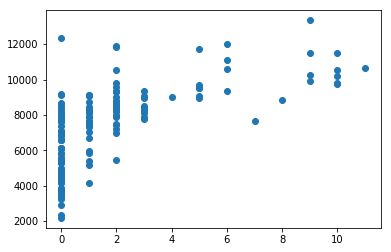

In [55]:
plt.scatter(x=tiles_merged['Cluster Labels'], y=tiles_merged['prix_m2'])
plt.show()

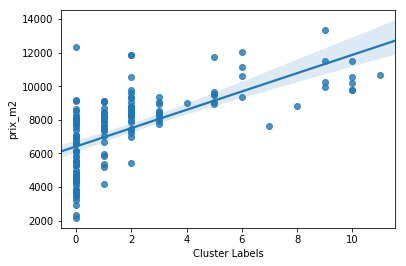

In [56]:
sns.regplot(x=tiles_merged['Cluster Labels'], y=tiles_merged['prix_m2'])

Data are quite dispersed and there is no obvious correlation. Let's perform a "stupid" linear regression between the cluster label (from 0 to 11) and the price per square meter.

In [57]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
x = np.asanyarray(tiles_merged[['Cluster Labels']])
y = np.asanyarray(tiles_merged[['prix_m2']])

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=7)

regr.fit (x_train, y_train)

# The coefficients
print ('Coefficients: ', regr.coef_)
print ('Intercept: ', regr.intercept_)
print('Variance score: %.2f' % regr.score(x_train, y_train))
print('Variance score: %.2f' % regr.score(x_test, y_test))

Coefficients:  [[492.96012194]]
Intercept:  [6474.56872465]
Variance score: 0.39
Variance score: 0.48


With no surprise, we get a quite poor variance score of 0.48.

Now let's use a more clever linear regression. We will use a one hot encoding in order to classify the cluster of each tile. Than, we will do a multiple linear regression in order to model the price per square meter of each tile through the associated segment of its venues.

In [60]:
# one hot encoding
clist = list("C{:02d}".format(k) for k in list (venues_grouped_cluster['Cluster Labels']))

cluster_onehot = pd.get_dummies(clist, prefix="", prefix_sep="")

# add neighborhood column back to dataframe
cluster_onehot['tile_id'] = venues_grouped_cluster['tile_id']
cluster_onehot['nombre_venues'] = venues_grouped_cluster['nombre_venues']

cluster_onehot.tail(10)

C00  C01  C02  C03  C04  C05  C06  C07  C08  C09  C10  C11 tile_id  \
141    1    0    0    0    0    0    0    0    0    0    0    0   14_00   
142    0    1    0    0    0    0    0    0    0    0    0    0   14_01   
143    0    1    0    0    0    0    0    0    0    0    0    0   14_02   
144    1    0    0    0    0    0    0    0    0    0    0    0   14_03   
145    0    1    0    0    0    0    0    0    0    0    0    0   14_04   
146    0    0    1    0    0    0    0    0    0    0    0    0   14_05   
147    0    0    1    0    0    0    0    0    0    0    0    0   14_07   
148    1    0    0    0    0    0    0    0    0    0    0    0   14_08   
149    1    0    0    0    0    0    0    0    0    0    0    0   14_09   
150    1    0    0    0    0    0    0    0    0    0    0    0   15_06   

     nombre_venues  
141             11  
142             22  
143             22  
144             16  
145             14  
146             33  
147             27  
148             12  
149             10  
150              6

We will split the feature X dataset (represented by the Cluster labels per tile ) and the y dataset (the average price per square meter per tile) into a train and test set.

Than we will aplly a Ridge multiple repression algorithm - with regularisation. The RidgeCV method will automaticaly chose the optimal alpha parameter, which will be chosen between 0.00001 and 10000.

In [61]:
X_features = cluster_onehot.drop(['nombre_venues'], 1).set_index('tile_id')
X_features.head()

C00  C01  C02  C03  C04  C05  C06  C07  C08  C09  C10  C11
tile_id                                                            
00_13      1    0    0    0    0    0    0    0    0    0    0    0
00_14      1    0    0    0    0    0    0    0    0    0    0    0
01_01      1    0    0    0    0    0    0    0    0    0    0    0
01_02      1    0    0    0    0    0    0    0    0    0    0    0
01_03      1    0    0    0    0    0    0    0    0    0    0    0

In [62]:
Y = tiles_merged[['tile_id', 'prix_m2']].set_index('tile_id')
Y.head()

prix_m2
tile_id             
00_13    4731.721471
00_14    4788.432368
01_01    8161.830850
01_02    7737.428188
01_03    7066.006600

In [63]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_features, Y, test_size=0.30, random_state=7)

reg = linear_model.RidgeCV(alphas=np.logspace(-5, 5, 25))
reg.fit(X_train, y_train)

RidgeCV(alphas=array([1.00000e-05, 2.61016e-05, 6.81292e-05, 1.77828e-04, 4.64159e-04,
       1.21153e-03, 3.16228e-03, 8.25404e-03, 2.15443e-02, 5.62341e-02,
       1.46780e-01, 3.83119e-01, 1.00000e+00, 2.61016e+00, 6.81292e+00,
       1.77828e+01, 4.64159e+01, 1.21153e+02, 3.16228e+02, 8.25404e+02,
       2.15443e+03, 5.62341e+03, 1.46780e+04, 3.83119e+04, 1.00000e+05]),
    cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring=None, store_cv_values=False)

What variance score do we get now?

In [64]:
print ('Intercept: ', reg.intercept_)
print ('Alpha: ', reg.alpha_)
print('Variance score train: %.2f' % reg.score(X_train, y_train))
print('Variance score test: %.2f' % reg.score(X_test, y_test))    

Intercept:  [8873.06823306]
Alpha:  0.3831186849557293
Variance score train: 0.53
Variance score test: 0.55


It looks better than the simple linear regression based on the number of venues. However, we are at only 0.55.

### IV.3 Multiple linear regression based on venue categories

In [66]:
X_features = venues_grouped_cluster.drop(['Cluster Labels', 'nombre_venues'], 1).set_index('tile_id')
X_features.head()

Accessories Store  Afghan Restaurant  African Restaurant  \
tile_id                                                             
00_13                    0                  0                   0   
00_14                    0                  0                   0   
01_01                    0                  0                   0   
01_02                    0                  0                   0   
01_03                    0                  0                   0   

         Alsatian Restaurant  American Restaurant  Aquarium  Arepa Restaurant  \
tile_id                                                                         
00_13                      0                    0         0                 0   
00_14                      0                    0         0                 0   
01_01                      0                    0         0                 0   
01_02                      0                    0         0                 0   
01_03                      0                    0         0                 0   

         Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
tile_id                                                                         
00_13                         0            0           0                    0   
00_14                         0            0           0                    0   
01_01                         0            0           0                    0   
01_02                         0            0           0                    0   
01_03                         0            0           0                    0   

         Asian Restaurant  Athletics & Sports  Auto Dealership  Auto Garage  \
tile_id                                                                       
00_13                   0                   0                0            0   
00_14                   0                   0                0            0   
01_01                   0                   0                0            0   
01_02                   0                   0                0            0   
01_03                   5                   0                0            0   

         Auto Workshop  Automotive Shop  Auvergne Restaurant  BBQ Joint  \
tile_id                                                                   
00_13                0                0                    0          0   
00_14                0                0                    0          0   
01_01                0                0                    0          0   
01_02                0                0                    0          0   
01_03                0                0                    0          0   

         Baby Store  Bagel Shop  Bakery  Bar  Baseball Stadium  \
tile_id                                                          
00_13             0           0       1    0                 0   
00_14             0           0       0    0                 0   
01_01             0           0       1    0                 0   
01_02             0           0       0    0                 0   
01_03             0           0       0    0                 0   

         Basketball Court  Basque Restaurant  Beach  Bed & Breakfast  \
tile_id                                                                
00_13                   0                  0      0                0   
00_14                   0                  0      0                0   
01_01                   0                  0      0                0   
01_02                   0                  0      0                0   
01_03                   0                  0      0                0   

         Beer Bar  Beer Garden  Beer Store  Big Box Store  \
tile_id                                                     
00_13           0            0           0              0   
00_14           0            0           0              0   
01_01           0            0           0              0   
01_02           0            0      

In [67]:
Y = tiles_merged[['tile_id', 'prix_m2']].set_index('tile_id')
Y.head()

prix_m2
tile_id             
00_13    4731.721471
00_14    4788.432368
01_01    8161.830850
01_02    7737.428188
01_03    7066.006600

In [68]:
X_columns = pd.DataFrame(data={'Venue type':list(X_features.columns)})
X_columns.tail()

Venue type
319    Wings Joint
320  Women's Store
321    Yoga Studio
322            Zoo
323    Zoo Exhibit

Use Ridge algorithm with Cross Validation embedded - multiple linear regression based on venue types

In [69]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_features, Y, test_size=0.30, random_state=7)

In [70]:
reg = linear_model.RidgeCV(alphas=np.logspace(-5, 5, 25))
reg.fit(X_train, y_train)

RidgeCV(alphas=array([1.00000e-05, 2.61016e-05, 6.81292e-05, 1.77828e-04, 4.64159e-04,
       1.21153e-03, 3.16228e-03, 8.25404e-03, 2.15443e-02, 5.62341e-02,
       1.46780e-01, 3.83119e-01, 1.00000e+00, 2.61016e+00, 6.81292e+00,
       1.77828e+01, 4.64159e+01, 1.21153e+02, 3.16228e+02, 8.25404e+02,
       2.15443e+03, 5.62341e+03, 1.46780e+04, 3.83119e+04, 1.00000e+05]),
    cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring=None, store_cv_values=False)

In [71]:
print ('Intercept: ', reg.intercept_)
print ('Alpha: ', reg.alpha_)
print('Variance score train: %.2f' % reg.score(X_train, y_train))
print('Variance score test: %.2f' % reg.score(X_test, y_test))
    
X_columns['Coefficients'] = reg.coef_[0]

Intercept:  [6146.61137982]
Alpha:  121.15276586285901
Variance score train: 0.59
Variance score test: 0.58


In [72]:
X_columns.sort_values(by=['Coefficients'])

Venue type  Coefficients
114                      Fast Food Restaurant   -121.959985
287                               Supermarket   -101.698526
133                               Gas Station    -66.304694
139                               Golf Course    -61.986008
54                                  Cafeteria    -60.746463
129                    Furniture / Home Store    -51.209251
306                             Train Station    -50.052391
15                              Auto Workshop    -45.481893
263                             Shopping Mall    -42.252343
50                              Burrito Place    -40.481473
107                         Electronics Store    -40.401135
260                        Seafood Restaurant    -40.145814
186                                    Market    -36.946562
173                                Kids Store    -33.162647
175                         Korean Restaurant    -32.585478
279                       Sporting Goods Shop    -32.504971
85                             Cosmetics Shop    -30.447315
198                       Moroccan Restaurant    -28.627659
149                   Health & Beauty Service    -27.730694
195                         Mobile Phone Shop    -27.730694
105                                 Drugstore    -27.730694
242                            Rental Service    -27.730694
192                        Mexican Restaurant    -27.571107
70                             Chocolate Shop    -25.920575
254                            Sandwich Place    -25.233156
209                              Noodle House    -24.957281
20                                 Bagel Shop    -23.999780
93                           Department Store    -23.903759
294                                  Tea Room    -23.494090
312                          Video Game Store    -23.473313
281                               Sports Club    -22.897839
166                       Japanese Restaurant    -22.812820
102                          Doner Restaurant    -21.951385
170                                 Juice Bar    -21.510354
154                              Home Service    -21.012698
276                                       Spa    -20.879905
110                                   Exhibit    -19.477055
82                 Construction & Landscaping    -19.060217
145                                  Gym Pool    -18.909754
266                              Skating Rink    -18.776836
141                          Greek Restaurant    -18.566766
239                               Record Shop    -17.656386
252                               Salad Place    -17.516633
30                                 Beer Store    -16.211669
27                            Bed & Breakfast    -15.974672
193                 Middle Eastern Restaurant    -15.801894
223                        Photography Studio    -15.593082
183                                    Lounge    -15.245591
16                            Automotive Shop    -14.877922
235                                       Pub    -14.874373
238                          Ramen Restaurant    -14.346252
190                               Men's Store    -14.127247
43                             Breakfast Spot    -13.656452
313                     Vietnamese Restaurant    -13.096720
200                             Movie Theater    -13.080248
100                                 Dive Spot    -12.902146
160                       Indie Movie Theater    -12.422810
201                                 Multiplex    -12.284517
59                                 Campground    -12.225494
83                          Convenience Store    -11.576531
53                                    Butcher    -11.501348
18                                  BBQ Joint    -11.385798
91                               Dance Studio    -11.372383
172                          Kebab Restaurant    -11.065728
240                          Recording Studio    -10.870900
123                                Food Truck    -10.822411
293            

In [73]:
positive_venue_list = X_columns[X_columns['Coefficients'] > 50]

positive_venue_list.sort_values(by=['Coefficients'])
#paris_east_venues.head(50)

Venue type  Coefficients
297     Thai Restaurant     50.771778
61           Canal Lock     51.079223
258      Science Museum     52.328951
48         Burger Joint     53.932499
143                 Gym     54.482698
134           Gastropub     54.903016
71               Church     58.084208
95         Dessert Shop     59.634543
140        Gourmet Shop     62.820395
202              Museum     66.353349
215         Pastry Shop     66.628933
151       Historic Site     70.458681
131              Garden     76.223718
216    Pedestrian Plaza     82.405646
165  Italian Restaurant     83.968296
22                  Bar     86.299203
33               Bistro     86.579887
298             Theater     87.200830
76          Coffee Shop    102.902933
214                Park    117.389079
126   French Restaurant    145.403237
156               Hotel    164.445635
55                 Café    183.772523

In [74]:
positive_venues=paris_east_venues.merge(positive_venue_list, left_on='Venue Category', right_on='Venue type')
positive_venues=positive_venues.merge(tiles[['tile_id']], on='tile_id')
print(positive_venues.shape)
print(paris_east_venues.shape)

(1631, 10)
(4424, 8)


In [75]:
paris_east_map = paris_east()
paris_east_map = paris_price_m2 (paris_east_map)
paris_east_map

east_tiles.json


In [76]:
def paris_east_tiles (paris_map):
    workfile = r'east_tiles.json'
    print(workfile)

    folium.GeoJson(
        workfile
    ).add_to(paris_map)
    return (paris_map)

from folium.plugins import HeatMap

paris_east_map = paris_east()
paris_east_map = paris_east_tiles (paris_east_map)

good_latitudes = positive_venues['Venue Latitude'].values
good_longitudes = positive_venues['Venue Longitude'].values

good_locations = [[lat, lon] for lat, lon in zip(good_latitudes, good_longitudes)]

HeatMap(good_locations).add_to(paris_east_map)

paris_east_map

east_tiles.json


## V. Results and Discussion <a name="results"></a>

## VI. Conclusion <a name="conclusion"></a>

## Appendices

Some code to save and reload interesting dataframes

In [ ]:
paris_east_venues.to_csv('paris_east_venues_18_20200110_A.csv', index=False)
east_paris_transactions.to_csv('east_paris_transactions_18_20200110_A.csv', index=False)
tiles.to_csv('tiles_18_20200110_A.csv', index=False)

In [ ]:
paris_east_venues = pd.read_csv('paris_east_venues_18_20200110_A.csv')
#paris_east_venues2.head(10)
tiles = pd.read_csv('tiles_18_20200110_A.csv')
#tiles2.head(10)
east_paris_transactions = pd.read_csv('east_paris_transactions_18_20200110_A.csv')
#east_paris_transactions2.head(10)